<a href="https://colab.research.google.com/github/SuhrudhSarathy/ForestDeptProj/blob/main/TrainingResnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import numpy as np
import PIL
import matplotlib.pyplot as plt
import os
%matplotlib inline

dtype=torch.float
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Load the data
train_dir = "drive/MyDrive/Aero Forest Project/data/train"
test_dir = "drive/MyDrive/Aero Forest Project/data/test"
val_dir = "drive/MyDrive/Aero Forest Project/data/val"
pretrained_model = "drive/MyDrive/Aero Forest Project/resnet18_new.pth"

In [ ]:
from torchvision import models, transforms, datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
train_dataset = datasets.ImageFolder(train_dir, data_transforms["train"])
test_dataset = datasets.ImageFolder(test_dir, data_transforms["test"])
val_dataset = datasets.ImageFolder(val_dir, data_transforms["val"])

# Dataloaders
train_data = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_data = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
val_data = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
print(len(train_data), len(val_data))
print(train_dataset.classes)

255 255
['Acanthus Ilicifolius', 'Bruguiera cylindrica', 'Bruguiera gymnorrihza', 'Ceriops Tagal', 'Excoecaria Agallocha', 'Kandelia Candel', 'Lumnizera recemosa', 'Rhizophora apiculata']


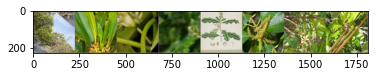

tensor([3, 3, 1, 0, 0, 4, 7, 3])


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

inputs, classes = next(iter(train_data))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)
print(classes)

In [ ]:
# Use a pretrained model to train
# Train it a bit naively for now
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv_net = models.resnet18(pretrained=True)
        print(self.conv_net)
        self.conv_net.fc = nn.Linear(self.conv_net.fc.in_features, len(train_dataset.classes))

        # Load the state dict from the drive after first train
        # self.load_state_dict(torch.load(pretrained_model, map_location=device))
        # Freeze the parameters of the convnet (if you want a feature extractor only)
        self.to(dtype).to(device)

    def forward(self, X):
        X = self.conv_net(X)
        # returns the class only
        _, preds = torch.max(X, 1)
        # Return both to use for training
        return X, preds

    def train_model(self, EPOCHS):
        self.optimiser = optim.SGD(self.parameters(), lr=1e-3, momentum=0.9)
        self.criterion = nn.CrossEntropyLoss()

        

        # Each phase consists of train and val step
        self.train_losses = []
        self.val_losses = []
        self.train_accuracy = []
        self.val_accuracy = []

        
        for epoch in range(EPOCHS):
            running_loss = 0
            running_i = 0
            running_coorects = 0
            # TRAIN
            self.train()
            for inputs, labels in tqdm(train_data):
                inputs = inputs.to(device)
                labels = labels.to(device)

                self.optimiser.zero_grad()

                vals, preds = self.forward(inputs)
                loss = self.criterion(vals, labels)

                loss.backward()
                self.optimiser.step()

                running_loss += loss.item() * inputs.size(0)
                running_coorects += torch.sum(preds == labels.data)

            self.train_losses.append(running_loss/len(train_data))
            self.train_accuracy.append(running_coorects.double()/(8*len(train_data)))

            running_loss = 0
            running_coorects = 0
            # EVAL
            self.eval()
            for inputs, labels in tqdm(val_data):
                inputs = inputs.to(device)
                labels = labels.to(device)

                self.optimiser.zero_grad()

                with torch.set_grad_enabled(False):
                    vals, preds = self.forward(inputs)
                    loss = self.criterion(vals, labels)

                    running_loss += loss.item() * inputs.size(0)
                    running_coorects += torch.sum(preds == labels.data)

            self.val_losses.append(running_loss/len(val_data))
            self.val_accuracy.append(running_coorects.double()/(8*len(val_data)))
            print()
            print(f"Epoch: {epoch + 1}, Val Loss: {self.val_losses[-1]}, Val Accuracy: {self.val_accuracy[-1]}, Train Loss: {self.train_losses[-1]}, Train Accuracy: {self.train_accuracy[-1]}")
            print()

In [ ]:
model = Model()

In [ ]:
model.train_model(25)

 92%|█████████▏| 234/255 [14:23<01:34,  4.48s/it]

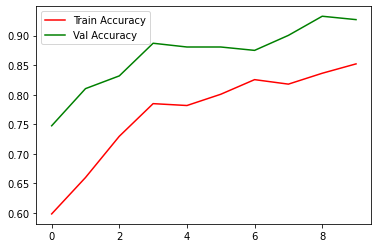

In [ ]:
plt.plot(model.train_accuracy, color="red", label="Train Accuracy")
plt.plot(model.val_accuracy, color="green", label="Val Accuracy")
plt.legend()

In [ ]:
# Lets try testing it
model.eval()
test_correct = 0
print(len(test_data))

for input, label in tqdm(test_data):
    break
    input = input.to(device)
    label = label.to(device)
    _, pred = model(input)
    if pred.item() == label.item():
        test_correct += 1
print(test_correct)
print(f"Accuracy: {test_correct * 100/len(test_data)}")

280


  0%|          | 0/280 [00:00<?, ?it/s]

Shape: torch.Size([1, 3, 224, 224])
0
Accuracy: 0.0


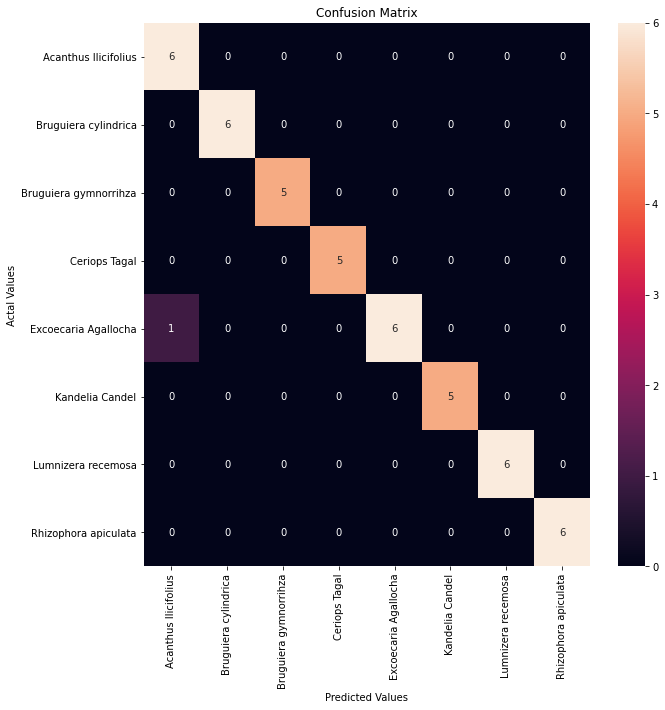

In [ ]:
# trying to make a confusion matrix as well
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
model.eval()
test_correct = 0
predicted_label = []
actual_label = []

logs = []

for input, label in test_data:
    input = input.to(device)
    label = label.to(device)

    val, pred = model(input)
    val_percent = F.softmax(val, dim=-1)
    logs.append(f"Percentage: {torch.max(val_percent).item()}, Predicted Class: {pred.item()}, Correct Class: {label.item()}")
    predicted_label.append(pred.item())
    actual_label.append(label.item())

    if pred.item() == label.item():
        test_correct += 1

cm = confusion_matrix(actual_label, predicted_label)
cm_df = pd.DataFrame(cm, index=train_dataset.classes, columns=train_dataset.classes)

# plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm_df, annot=True)
plt.title("Confusion Matrix")
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show();

In [ ]:
# Save the model to drive
torch.save(model.state_dict(), "/content/drive/MyDrive/Aero Forest Project/resnet18_new.pth")

In [ ]:
a = torch.tensor([1, 2, 3, 4, 5]).view(1, -1).to(dtype)
F.softmax(a, dim=-1)

tensor([[0.0117, 0.0317, 0.0861, 0.2341, 0.6364]])

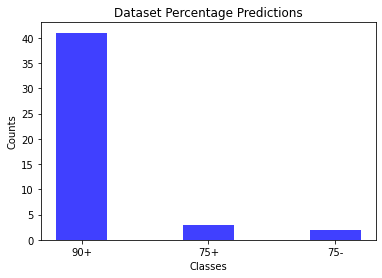

In [ ]:
# Try and plot the percentages like a bar plot
ninty_plus = 0
seventy_five_plus = 0
seventy_five_less = 0

for entry in logs:
    entry = entry.split()
    accuracies = float(entry[1].replace(",", ''))
    if accuracies > 0.9:
        ninty_plus += 1
    elif 0.75 <= accuracies <= 0.9:
        seventy_five_plus += 1
    else:
        seventy_five_less += 1

cats = ["90+", "75+", "75-"]
counts = [ninty_plus, seventy_five_plus, seventy_five_less]


plt.bar(cats, counts, color ='blue', width = 0.4, alpha=0.75)
 
plt.xlabel("Classes")
plt.ylabel("Counts")
plt.title("Dataset Percentage Predictions")
plt.show()